<a href="https://www.kaggle.com/code/hli111111/sklearn-in-pytorch-with-gpu?scriptVersionId=158630338" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import torch
from torch.utils.data import DataLoader, TensorDataset

class TorchLinearRegression:
    def __init__(self, fit_intercept=True, n_iter=1000, learning_rate=0.01, device='cpu'):
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.device = device

    def fit(self, X, y, batch_size=32):
        X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Adding bias term in weights for intercept
        n_features = X.shape[1] + 1 if self.fit_intercept else X.shape[1]
        self.weights = torch.zeros(n_features, device=self.device, requires_grad=True)

        for _ in range(self.n_iter):
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                if self.fit_intercept:
                    ones = torch.ones(X_batch.shape[0], 1, device=self.device)
                    X_batch = torch.cat((ones, X_batch), 1)

                y_pred = torch.matmul(X_batch, self.weights)
                loss = torch.mean((y_pred - y_batch) ** 2)
                loss.backward()

                with torch.no_grad():
                    self.weights -= self.learning_rate * self.weights.grad
                    self.weights.grad.zero_()

        if self.fit_intercept:
            self.intercept_ = self.weights[0].item()
            self.coef_ = self.weights[1:].cpu().detach().numpy()
        else:
            self.intercept_ = 0.0
            self.coef_ = self.weights.cpu().detach().numpy()

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        if self.fit_intercept:
            ones = torch.ones(X.shape[0], 1, device=self.device)
            X = torch.cat((ones, X.to(self.device)), 1)

        y_pred = torch.matmul(X, self.weights).cpu()
        return y_pred.detach().numpy()


# Sklearn models rewritten in pytorch to use GPU

Hao Li

This code is experimental and has to go through some checking before making a package.

This is done because: installation of pytorch is everywhere
Why not use torch to compute some of the traditional models as well? 
Also, it is possible to make torch conform to sklearn's grammar, making it almost plug and play.
Here are some of the results
& I show you that sklearn and packages in sklearn style (like linear-tree) can work with these functions seamlessly.

I am looking for some comments on the code (and if you can help check code correctness etc.)
This is on GitHub at 
github.com/HaoLi111/ML_Biostats/sklearn-in-pytorch-with-gpu.ipynb

In [2]:
!pip install /kaggle/input/tabular-local-prediction-pkgs/linear_tree-0.3.5-py3-none-any.whl --no-deps

Processing /kaggle/input/tabular-local-prediction-pkgs/linear_tree-0.3.5-py3-none-any.whl


In [3]:
class TorchElasticNet:
    def __init__(self, alpha=1.0, l1_ratio=0.5, n_iter=1000, learning_rate=0.01, fit_intercept=True, device='cpu'):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.fit_intercept = fit_intercept
        self.device = device

    def fit(self, X, y, batch_size=32):
        X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        n_features = X.shape[1] + 1 if self.fit_intercept else X.shape[1]
        self.weights = torch.zeros(n_features, device=self.device, requires_grad=True)

        for _ in range(self.n_iter):
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                if self.fit_intercept:
                    ones = torch.ones(X_batch.shape[0], 1, device=self.device)
                    X_batch = torch.cat((ones, X_batch), 1)

                predictions = torch.matmul(X_batch, self.weights)
                residuals = predictions - y_batch
                loss = torch.mean(residuals ** 2)
                
                l1_penalty = self.l1_ratio * torch.sum(torch.abs(self.weights))
                l2_penalty = (1 - self.l1_ratio) * torch.sum(self.weights ** 2)
                loss += self.alpha * (l1_penalty + l2_penalty)

                loss.backward()
                with torch.no_grad():
                    self.weights -= self.learning_rate * self.weights.grad
                    self.weights.grad.zero_()

        if self.fit_intercept:
            self.intercept_ = self.weights[0].item()
            self.coef_ = self.weights[1:].cpu().detach().numpy()
        else:
            self.intercept_ = 0.0
            self.coef_ = self.weights.cpu().detach().numpy()
    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        if self.fit_intercept:
            ones = torch.ones(X.shape[0], 1, device=self.device)
            X = torch.cat((ones, X.to(self.device)), 1)

        predictions = torch.matmul(X, self.weights).cpu()
        return predictions.detach().numpy()


In [4]:
from sklearn.datasets import make_regression

# Generate dataset
X, y = make_regression(n_samples=100, n_features=1, noise=10)


# Initialize and train TorchLinearRegression
linear_model = TorchElasticNet(device='cuda')
linear_model.fit(X, y, batch_size=10)

# Make predictions
linear_predictions = linear_model.predict(X)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


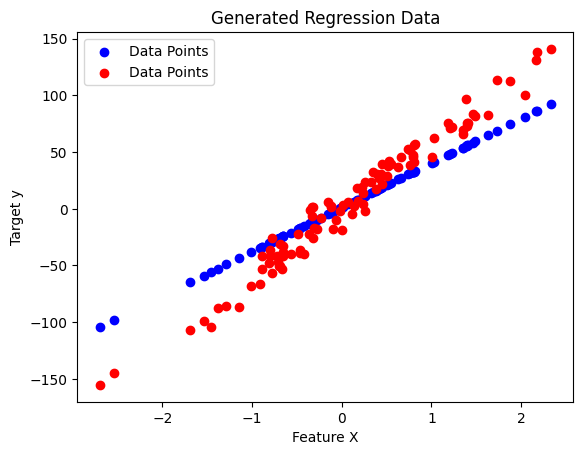

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# Plotting the generated data
plt.scatter(X[:,0], linear_predictions, color='blue', label='Data Points')

plt.scatter(X[:,0], y, color='red', label='Data Points')
plt.title('Generated Regression Data')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.legend()
plt.show()


In [6]:
model = TorchLinearRegression(device='cuda')  # or device='cuda' if you prefer and if it's available
model.fit(X, y)

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class TorchSGDClassifier:
    def __init__(self, n_iter=1000, learning_rate=0.01, fit_intercept=True, device='cpu'):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.fit_intercept = fit_intercept
        self.device = device

    def fit(self, X, y, batch_size=32):
        X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        n_features = X.shape[1] + 1 if self.fit_intercept else X.shape[1]
        n_classes = len(torch.unique(y))

        # Simple linear model with softmax for classification
        self.model = nn.Linear(n_features, n_classes).to(self.device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)

        for _ in range(self.n_iter):
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                if self.fit_intercept:
                    ones = torch.ones(X_batch.shape[0], 1, device=self.device)
                    X_batch = torch.cat((ones, X_batch), 1)

                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        self.coef_ = self.model.weight.cpu().detach().numpy()
        self.intercept_ = self.model.bias.cpu().detach().numpy()

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        X = X.to(self.device)
        if self.fit_intercept:
            ones = torch.ones(X.shape[0], 1, device=self.device)
            X = torch.cat((ones, X), 1)

        
        outputs = self.model(X)
        _, predicted = torch.max(outputs.data, 1)
        return predicted.cpu().numpy()


In [8]:
from sklearn.datasets import make_classification

# Generate a synthetic dataset for classification
X, y = make_classification(n_samples=100, n_features=4, n_classes=2, n_clusters_per_class=1, random_state=0)


# Assuming you have a dataset X, y where y are class labels
classifier = TorchSGDClassifier(device='cuda' if torch.cuda.is_available() else 'cpu')
classifier.fit(X, y, batch_size=10)

# Predictions
predictions = classifier.predict(X)


In [9]:
# !pip install linear-tree

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class TorchLinearRegressionNN(nn.Module):
    def __init__(self, device='cpu', fit_intercept = True):
        super(TorchLinearRegressionNN, self).__init__()
        self.linear = None  # Initialize linear layer later
        self.device = device
        self.fit_intercept = fit_intercept
        # Initialize attributes for coefficients and intercept
        self.coef_ = None
        self.intercept_ = None

    def forward(self, x):
        return self.linear(x)

    def fit(self, X, y, n_iter=1000, learning_rate=0.01, batch_size=32):
        # Detect number of features
        n_features = X.shape[1]

        # Initialize linear layer now that we know n_features
        self.linear = nn.Linear(n_features, 1).to(self.device)

        self.train()  # Set the model to training mode
        X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()  # Mean Squared Error Loss
        optimizer = torch.optim.SGD(self.linear.parameters(), lr=learning_rate)

        for _ in range(n_iter):
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                optimizer.zero_grad()
                outputs = self.forward(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        # Store the coefficients and intercept after training
        with torch.no_grad():
            self.coef_ = self.linear.weight.data.cpu().numpy().flatten()
            self.intercept_ = self.linear.bias.data.cpu().numpy().item()

    def predict(self, X):
        self.eval()  # Set the model to evaluation mode
        X = torch.tensor(X, dtype=torch.float32)
        X = X.to(self.device)
        with torch.no_grad():
            predictions = self.forward(X)
        return predictions.cpu().detach().numpy().flatten()


In [11]:
from sklearn.linear_model import LinearRegression
from lineartree import LinearTreeRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=1,
                       #n_informative=2, n_targets=1,
                       random_state=0, shuffle=False,
                       noise = 10)
regr = LinearTreeRegressor(base_estimator=TorchLinearRegressionNN(device='cuda'))
regr.fit(X, y)

LinearTreeRegressor(base_estimator=TorchLinearRegressionNN())

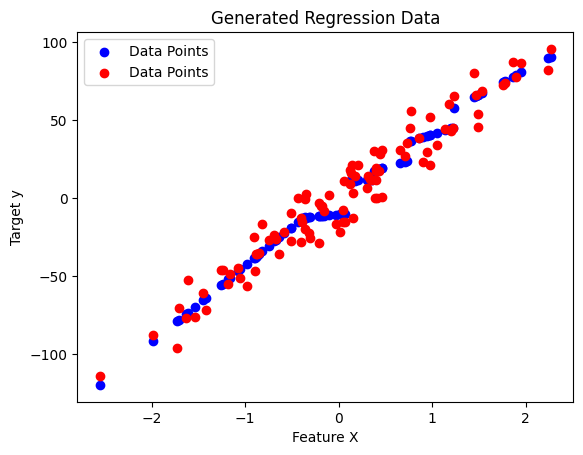

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# Plotting the generated data
plt.scatter(X[:,0], regr.predict(X), color='blue', label='Data Points')

plt.scatter(X[:,0], y, color='red', label='Data Points')
plt.title('Generated Regression Data')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.legend()
plt.show()


In [13]:
from sklearn.linear_model import LinearRegression
from lineartree import LinearTreeRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=4,
                       n_informative=2, n_targets=1,
                       random_state=0, shuffle=False)
regr = LinearTreeRegressor(base_estimator=TorchLinearRegression(device = 'cuda'))
regr.fit(X, y)

LinearTreeRegressor(base_estimator=<__main__.TorchLinearRegression object at 0x7ea61cbbb1c0>)

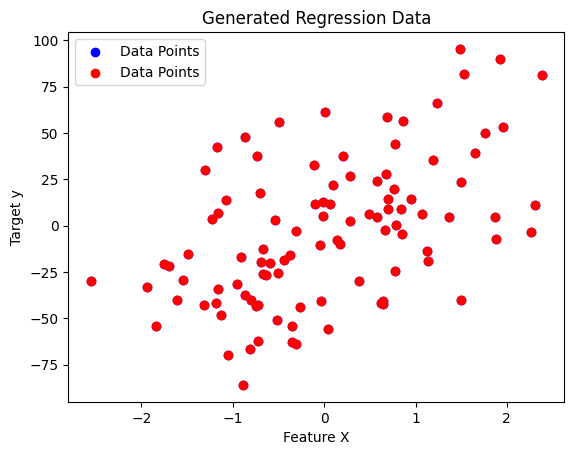

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# Plotting the generated data
plt.scatter(X[:,0], regr.predict(X), color='blue', label='Data Points')

plt.scatter(X[:,0], y, color='red', label='Data Points')
plt.title('Generated Regression Data')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.legend()
plt.show()

In [15]:
import torch

class TorchMatrixBasedLinearRegression:
    def __init__(self, fit_intercept=True, device='cpu'):
        self.fit_intercept = fit_intercept
        self.device = device
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        X, y = X.to(self.device), y.to(self.device)

        if self.fit_intercept:
            ones = torch.ones(X.shape[0], 1, device=self.device)
            X = torch.cat((ones, X), 1)

        # Solving the normal equation
        X_transpose = torch.transpose(X, 0, 1)
        beta = torch.matmul(torch.matmul(torch.linalg.pinv(torch.matmul(X_transpose, X)), X_transpose), y)

        if self.fit_intercept:
            self.intercept_ = beta[0].item()
            self.coef_ = beta[1:].cpu().detach().numpy()
        else:
            self.intercept_ = 0.0
            self.coef_ = beta.cpu().detach().numpy()

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        X = X.to(self.device)

        if self.fit_intercept:
            # Add a column of ones to X for the intercept
            ones = torch.ones(X.shape[0], 1, device=self.device)
            X = torch.cat((ones, X), 1)

            # Combine intercept with coefficients
            intercept_tensor = torch.tensor([self.intercept_], device=self.device)
            coef_tensor = torch.tensor(self.coef_, device=self.device).flatten()
            combined_coef = torch.cat((intercept_tensor, coef_tensor))
        else:
            # Use coefficients only
            combined_coef = torch.tensor(self.coef_, device=self.device).flatten()

        predictions = torch.matmul(X, combined_coef)
        return predictions.cpu().detach().numpy()




In [16]:
from sklearn.datasets import make_regression

# Generate dataset
X, y = make_regression(n_samples=100, n_features=1, noise=10)


# Initialize and train TorchLinearRegression
linear_model = TorchLinearRegressionNN(device='cuda', )
linear_model.fit(X, y, )

# Make predictions
linear_predictions = linear_model.predict(X)


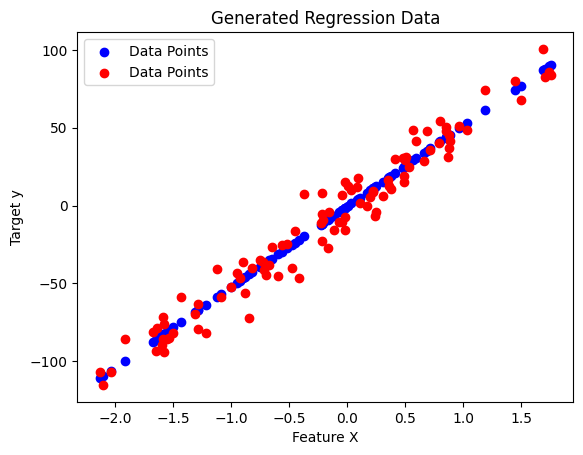

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# Plotting the generated data
plt.scatter(X[:,0], linear_predictions, color='blue', label='Data Points')

plt.scatter(X[:,0], y, color='red', label='Data Points')
plt.title('Generated Regression Data')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.legend()
plt.show()

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class LogisticRegressionNN(nn.Module):
    def __init__(self, n_features, device='cpu'):
        super(LogisticRegressionNN, self).__init__()
        self.linear = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()
        self.device = device
        self.to(device)

        # Initialize attributes for coefficients and intercept
        self.coef_ = None
        self.intercept_ = None

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

    def fit(self, X, y, n_iter=1000, learning_rate=0.01, batch_size=32):
        self.train()
        X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)

        for _ in range(n_iter):
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                optimizer.zero_grad()
                outputs = self.forward(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        # Store the coefficients and intercept after training
        with torch.no_grad():
            self.coef_ = self.linear.weight.data.cpu().numpy().flatten()
            self.intercept_ = self.linear.bias.data.cpu().numpy().item()

    def predict(self, X):
        self.eval()
        X = torch.tensor(X, dtype=torch.float32)
        X = X.to(self.device)
        with torch.no_grad():
            outputs = self.forward(X)
        predictions = (outputs.cpu().numpy() > 0.5).astype(int)
        return predictions
    
    def predict_proba(self, X):
        self.eval()
        X = torch.tensor(X, dtype=torch.float32)
        X = X.to(self.device)
        with torch.no_grad():
            outputs = self.forward(X)
        predictions = (outputs.cpu().numpy()).astype(float)
        return predictions
        


In [19]:
# Assuming you have a dataset X, y for a binary classification task
n_features = X.shape[1]
model = LogisticRegressionNN(n_features, device='cuda' if torch.cuda.is_available() else 'cpu')
model.fit(X, y, n_iter=1000, learning_rate=0.01, batch_size=32)

# Predictions
predictions = model.predict(X)


In [20]:
predictions

array([[1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
    

In [21]:
model.coef_

array([61.00167], dtype=float32)

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class TabularMLP(nn.Module):
    def __init__(self, input_features, output_features, layers, task_type='regression', device='cpu'):
        super(TabularMLP, self).__init__()
        self.device = device
        self.task_type = task_type

        # Build the MLP layers
        all_layers = []
        for i in range(len(layers)):
            input_dim = input_features if i == 0 else layers[i - 1]
            output_dim = layers[i]
            all_layers.append(nn.Linear(input_dim, output_dim))
            all_layers.append(nn.ReLU())  # Using ReLU as the activation function

        # Output layer
        if task_type == 'classification':
            all_layers.append(nn.xLinear(layers[-1], output_features))
            all_layers.append(nn.Sigmoid())# if output_features == 1 else nn.Softmax(dim=1))
        else:  # Default to regression
            all_layers.append(nn.Linear(layers[-1], output_features))

        # Combine all layers
        self.layers = nn.Sequential(*all_layers)
        self.to(device)    
    
    def forward(self, x):
        return self.layers(x)


    def fit(self, X, y, n_iter=1000, learning_rate=0.01, batch_size=32, X_test=None, y_test=None):
        self.train()  # Set the model to training mode
        X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)

        # Initialize loss history
        self.train_loss_history = []
        self.test_loss_history = []

        # Check if test data is provided
        test_data_provided = X_test is not None and y_test is not None
        if test_data_provided:
            X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
            test_dataset = TensorDataset(X_test, y_test)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

        for epoch in range(n_iter):
            # Training loop
            train_loss_accum = 0.0
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                optimizer.zero_grad()
                outputs = self.forward(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss_accum += loss.item()

            # Average training loss for this epoch
            avg_train_loss = train_loss_accum / len(dataloader)
            self.train_loss_history.append(avg_train_loss)

            if test_data_provided:
                # Evaluation loop (test data)
                self.eval()  # Set the model to evaluation mode
                test_loss_accum = 0.0
                with torch.no_grad():
                    for X_batch, y_batch in test_dataloader:
                        X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                        outputs = self.forward(X_batch)
                        loss = criterion(outputs, y_batch)
                        test_loss_accum += loss.item()

                # Average test loss for this epoch
                avg_test_loss = test_loss_accum / len(test_dataloader)
                self.test_loss_history.append(avg_test_loss)

                self.train()  # Set the model back to training mode


    def predict(self, X):
        self.eval()  # Set the model to evaluation mode
        X = torch.tensor(X, dtype=torch.float32)
        X = X.to(self.device)
        with torch.no_grad():
            predictions = self.forward(X)
        return predictions.cpu().detach().numpy()
    
    def predict_proba(self, X):
        """Predict class probabilities for X."""
        if self.task_type != 'classification':
            raise ValueError("predict_proba is available only for classification tasks")

        self.eval()  # Set the model to evaluation mode
        X = torch.tensor(X, dtype=torch.float32)
        X = X.to(self.device)

        with torch.no_grad():
            outputs = self.forward(X)

        if self.layers[-1].__class__ == nn.Sigmoid:
            # For binary classification, return the sigmoid output directly
            return outputs.cpu().numpy()
        else:
            # For multi-class classification, return softmax probabilities
            probabilities = nn.functional.softmax(outputs, dim=1)
            return probabilities.cpu().numpy()


In [23]:
# Assuming you have a dataset X, y for training and X_test, y_test for testing
model = TabularMLP(input_features=1, output_features=1, layers=[1,2,2], device='cuda' if torch.cuda.is_available() else 'cpu')
model.fit(X, y, n_iter=1000, learning_rate=0.01, batch_size=32)#, X_test=X_test, y_test=y_test)

# Access the loss history
train_loss_history = model.train_loss_history
test_loss_history = model.test_loss_history

# Predictions
predictions = model.predict(X)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [24]:
# !pip install safeeval

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import ast
# import safe_eval

class TorchEvalTabularMLP(nn.Module):
    def __init__(self, layers, device='cpu'):
        super(TorchEvalTabularMLP, self).__init__()
        # super(TabularMLP, self).__init__()
        self.device = device
        # self.task_type = task_type

        # Combine all layers
        self.layers = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.layers(x)


    def fit(self, X, y, n_iter=1000, learning_rate=0.01, batch_size=32, X_test=None, y_test=None):
        self.train()  # Set the model to training mode
        X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)

        # Initialize loss history
        self.train_loss_history = []
        self.test_loss_history = []

        # Check if test data is provided
        test_data_provided = X_test is not None and y_test is not None
        if test_data_provided:
            X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
            test_dataset = TensorDataset(X_test, y_test)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

        for epoch in range(n_iter):
            # Training loop
            train_loss_accum = 0.0
            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                optimizer.zero_grad()
                outputs = self.forward(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss_accum += loss.item()

            # Average training loss for this epoch
            avg_train_loss = train_loss_accum / len(dataloader)
            self.train_loss_history.append(avg_train_loss)

            if test_data_provided:
                # Evaluation loop (test data)
                self.eval()  # Set the model to evaluation mode
                test_loss_accum = 0.0
                with torch.no_grad():
                    for X_batch, y_batch in test_dataloader:
                        X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                        outputs = self.forward(X_batch)
                        loss = criterion(outputs, y_batch)
                        test_loss_accum += loss.item()

                # Average test loss for this epoch
                avg_test_loss = test_loss_accum / len(test_dataloader)
                self.test_loss_history.append(avg_test_loss)

                self.train()  # Set the model back to training mode


    def predict(self, X):
        self.eval()  # Set the model to evaluation mode
        X = torch.tensor(X, dtype=torch.float32)
        X = X.to(self.device)
        with torch.no_grad():
            predictions = self.forward(X)
        return predictions.cpu().detach().numpy()
    
    def predict_proba(self, X):
        """Predict class probabilities for X."""
        if self.task_type != 'classification':
            raise ValueError("predict_proba is available only for classification tasks")

        self.eval()  # Set the model to evaluation mode
        X = torch.tensor(X, dtype=torch.float32)
        X = X.to(self.device)

        with torch.no_grad():
            outputs = self.forward(X)

        if self.layers[-1].__class__ == nn.Sigmoid:
            # For binary classification, return the sigmoid output directly
            return outputs.cpu().numpy()
        else:
            # For multi-class classification, return softmax probabilities
            probabilities = nn.functional.softmax(outputs, dim=1)
            return probabilities.cpu().numpy()

# Example usage
model = TorchEvalTabularMLP(
    layers=[
        nn.Linear(1, 8), 
        nn.ReLU(), 
        nn.Linear(8, 1),
    ],
    # task_type='regression',
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

model.fit(X, y, n_iter=1000, learning_rate=0.01, batch_size=32)#, X_test=X_test, y_test=y_test)

# Access the loss history
train_loss_history = model.train_loss_history
test_loss_history = model.test_loss_history

# Predictions
predictions = model.predict(X)
print(predictions)

[[-10.944389 ]
 [-17.11859  ]
 [ -7.850191 ]
 [-19.495163 ]
 [-10.944389 ]
 [-18.120792 ]
 [ -9.699782 ]
 [ -9.911856 ]
 [-10.944389 ]
 [-17.584366 ]
 [-10.637343 ]
 [-10.216347 ]
 [-16.708244 ]
 [-20.547287 ]
 [-10.944389 ]
 [-10.37703  ]
 [ -8.998785 ]
 [-20.197113 ]
 [ -9.724338 ]
 [-15.897915 ]
 [-10.919957 ]
 [-17.974247 ]
 [-17.681166 ]
 [-14.283702 ]
 [-10.794681 ]
 [-12.54054  ]
 [ -7.8054743]
 [ -9.786093 ]
 [-10.944389 ]
 [ -7.729004 ]
 [-10.42719  ]
 [-10.944389 ]
 [-14.938685 ]
 [-11.14939  ]
 [-10.944389 ]
 [-10.944389 ]
 [-13.214961 ]
 [ -7.6926026]
 [-13.371989 ]
 [-10.585769 ]
 [-10.929653 ]
 [-10.944389 ]
 [-17.298897 ]
 [-10.944389 ]
 [-17.605833 ]
 [-15.889595 ]
 [-20.722466 ]
 [-12.262897 ]
 [-10.990745 ]
 [ -9.886886 ]
 [-10.944389 ]
 [-10.944389 ]
 [-10.944389 ]
 [-17.416565 ]
 [-17.897741 ]
 [-10.944389 ]
 [ -9.361221 ]
 [-11.282585 ]
 [ -8.413235 ]
 [-10.944389 ]
 [-10.873131 ]
 [-10.1617155]
 [-10.944389 ]
 [-10.944389 ]
 [-11.75823  ]
 [-10.944389 ]
 [-10.9443

In [26]:
len(y)

100

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

class RBFKernelSVM(nn.Module):
    def __init__(self, gamma, device='cpu'):
        super(RBFKernelSVM, self).__init__()
        self.gamma = gamma
        self.device = device
        self.to(device)

    def rbf_kernel(self, X1, X2):
        # Calculate the RBF kernel between each pair of points
        X1_square = torch.sum(X1 ** 2, dim=1).view(-1, 1)
        X2_square = torch.sum(X2 ** 2, dim=1).view(1, -1)
        distance = X1_square + X2_square - 2 * torch.matmul(X1, X2.t())
        return torch.exp(-self.gamma * distance)

    def forward(self, X, support_vectors, coefficients, intercept):
        # Calculate the decision function
        kernel = self.rbf_kernel(X, support_vectors)
        return torch.matmul(kernel, coefficients) + intercept

    def fit(self, X, y, lr=0.01, epochs=100, batch_size=32):
        X, y = torch.tensor(X, dtype=torch.float32).to(self.device), torch.tensor(y, dtype=torch.float32).to(self.device)
        y = 2 * y - 1  # Convert labels to -1, 1 format

        # Initialize parameters
        coefficients = torch.randn(X.size(0), requires_grad=True, device=self.device)
        intercept = torch.randn(1, requires_grad=True, device=self.device)

        optimizer = optim.SGD([coefficients, intercept], lr=lr)
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for X_batch, y_batch in loader:
                optimizer.zero_grad()

                # Compute hinge loss for the batch
                distances = self.forward(X_batch, X, coefficients, intercept)
                hinge_loss = torch.mean(torch.clamp(1 - y_batch * distances, min=0))

                # Add regularization term
                loss = hinge_loss + 1 / (2 * X.size(0)) * torch.sum(coefficients ** 2)

                loss.backward()
                optimizer.step()

        # Extract support vectors
        support_mask = coefficients.detach() > 1e-5
        self.support_vectors = X[support_mask]
        self.coefficients = coefficients[support_mask]
        self.intercept = intercept.detach()

# Example usage
# X, y should be PyTorch tensors
model = RBFKernelSVM(gamma=1.0, device='cuda' if torch.cuda.is_available() else 'cpu')
model.fit(X, y, lr=0.01, epochs=100, batch_size=32)


In [28]:
import torch

class TorchKNN:
    def __init__(self, k=5, radius=float('inf'), device='cuda'):
        self.k = k
        self.radius = radius
        self.device = device
        self.data = None

    def fit(self, X):
        # Convert data to a tensor and transfer it to the specified device
        self.data = torch.tensor(X, dtype=torch.float32).to(self.device)

    def predict(self, X):
        # Convert query data to a tensor and transfer it to the specified device
        query = torch.tensor(X, dtype=torch.float32).to(self.device)

        # Compute pairwise distances
        dists = torch.cdist(self.data, query)

        # Apply radius constraint
        within_radius = dists <= self.radius

        # Get 'k' nearest neighbors within specified radius
        _, knn_indices = torch.topk(self.data[within_radius], k=self.k, largest=False)

        return knn_indices.cpu().numpy()

# Example Usage
knn = TorchKNN(k=5, radius=2.0, device='cuda')  # Use 'cpu' if GPU is not available
data = [[0, 1], [1, 1], [2, 2], [3, 3]]
query = [[1, 0], [2, 1]]

knn.fit(data)
indices = knn.predict(query)


In [29]:
indices

array([0, 3, 1, 2, 4])

In [30]:
import torch

class KNNRegressor:
    def __init__(self, k=5, radius=float('inf'), device='cuda'):
        self.k = k
        self.radius = radius
        self.device = device
        self.data = None
        self.targets = None

    def fit(self, X, y):
        self.data = torch.tensor(X, dtype=torch.float32).to(self.device)
        self.targets = torch.tensor(y, dtype=torch.float32).to(self.device)

    def predict(self, X):
        query = torch.tensor(X, dtype=torch.float32).to(self.device)

        # Compute pairwise distances
        dists = torch.cdist(self.data, query)

        # Apply radius constraint
        within_radius = dists <= self.radius

        predictions = torch.zeros(query.shape[0], dtype=torch.float32)

        for i in range(query.shape[0]):
            valid_dists = dists[:, i][within_radius[:, i]]
            valid_targets = self.targets[within_radius[:, i]]

            # Ensure k is not greater than the number of valid points
            k = min(self.k, valid_dists.shape[0])

            if k > 0:
                # Get indices of 'k' nearest neighbors
                _, idx = torch.topk(valid_dists, k=k, largest=False)

                # Calculate the mean of the target values of the nearest neighbors
                predictions[i] = valid_targets[idx].mean()

        return predictions.cpu().numpy()

# Example Usage
knn_regressor = KNNRegressor(k=3, device='cuda')  # Use 'cpu' if GPU is not available
# data = [[0, 1], [1, 1], [2, 2], [3, 3]]  # Example feature data
# targets = [0.5, 1.1, 2.2, 3.3]  # Corresponding target values
# query = [[1, 0], [2, 1]]  # Points for which we want to predict the target values

knn_regressor.fit(X,y)
predictions = knn_regressor.predict(X)


In [31]:
predictions

array([   3.719464 ,  -84.35841  ,   89.66134  , -102.703705 ,
         -2.7162807,  -84.65432  ,   41.223633 ,   47.593216 ,
         11.717033 ,  -80.52752  ,   21.533604 ,   37.36797  ,
        -75.42914  , -109.92546  ,   10.270132 ,   38.30875  ,
         57.89093  , -109.92546  ,   37.72941  ,  -70.81867  ,
         13.164133 ,  -84.65433  ,  -82.2953   ,  -47.572292 ,
         17.706747 ,  -41.477734 ,   89.66134  ,   43.278057 ,
         10.270132 ,   84.03194  ,   38.30875  ,   -3.703371 ,
        -60.672264 ,  -34.316734 ,    7.7192793,    3.719464 ,
        -56.1186   ,   84.03194  ,  -56.1186   ,   26.430912 ,
         13.164131 ,    2.2255607,  -84.35841  ,   -2.332286 ,
        -77.801926 ,  -70.81867  , -109.92546  ,  -36.444958 ,
        -18.578314 ,   47.593216 ,   -0.6152247,  -15.849396 ,
         -6.723259 ,  -88.32756  ,  -87.35509  ,  -13.672168 ,
         46.96029  ,  -27.10925  ,   82.75579  ,   11.431087 ,
         13.164131 ,   37.36797  ,  -18.578314 ,   -2.7

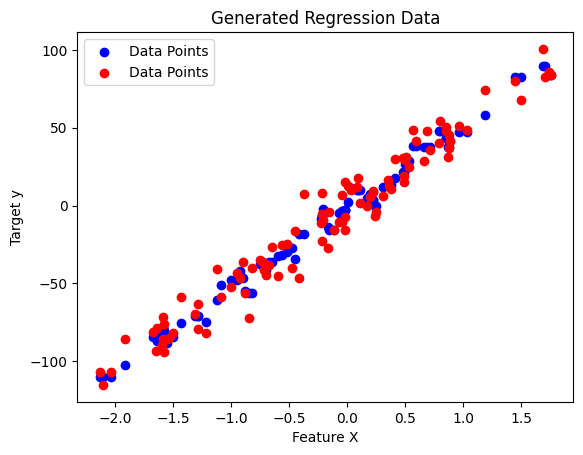

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# Plotting the generated data
plt.scatter(X[:,0], predictions, color='blue', label='Data Points')

plt.scatter(X[:,0], y, color='red', label='Data Points')
plt.title('Generated Regression Data')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.legend()
plt.show()

In [33]:
import torch

class GaussianNaiveBayes:
    def __init__(self, device='cuda'):
        self.device = device
        self.classes = None
        self.means = None
        self.vars = None
        self.priors = None

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        y = torch.tensor(y, dtype=torch.float32).to(self.device)
        self.classes = torch.unique(torch.tensor(y)).to(self.device)
        self.means = torch.zeros((len(self.classes), X.shape[1])).to(self.device)
        self.vars = torch.zeros((len(self.classes), X.shape[1])).to(self.device)
        self.priors = torch.zeros(len(self.classes)).to(self.device)

        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.means[i, :] = X_c.mean(0)
            self.vars[i, :] = X_c.var(0)
            self.priors[i] = float(X_c.shape[0]) / X.shape[0]

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        num_samples, num_features = X.shape
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        likelihoods = torch.zeros((num_samples, len(self.classes))).to(self.device)

        for i, c in enumerate(self.classes):
            # Apply Gaussian Naive Bayes formula
            likelihood = (
                -0.5 * torch.sum(torch.log(2 * torch.pi * self.vars[i]))
                -0.5 * torch.sum(((X - self.means[i]) ** 2) / self.vars[i], 1)
            )
            prior = torch.log(self.priors[i])
            likelihoods[:, i] = prior + likelihood

        return torch.argmax(likelihoods, 1).cpu().numpy()

# Example usage
gnb = GaussianNaiveBayes(device='cuda')  # Use 'cpu' if GPU is not available
data = [[-3, 7], [1, 5], [1, 2], [-2, 0], [2, 3], [-4, 0], [-1, 1], [1, 1], [-2, 2], [2, 7]]
labels = [3, 3, 3, 3, 4, 3, 3, 4, 3, 4]
query = [[0, 0], [2, 6]]

gnb.fit(data, labels)
predictions = gnb.predict(query)


/tmp/ipykernel_26/3009204202.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.classes = torch.unique(torch.tensor(y)).to(self.device)
/tmp/ipykernel_26/3009204202.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32).to(self.device)
